In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import mode

# Homework 3 

# Задача №1 - Лес или пустыня?

Часто при анализе изображений местности необходимо понять ее характер. В частности, если определить, что на изображении преобладет вода, то имеет смысл искать корабли на таком изображении. Если на картинке густой лес, то, возможно, это не лучшая зона для посадки дрона или беспилотника.

Ваша задача - написать программу, которая будет отличать лес от пустыни. В приложении можно найти реальные спутниковые снимки лесов и пустынь.

Примеры изображений:
<table><tr>
    <td> <img src="https://i.ibb.co/nmHHctW/test_image_00.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/dM77C4b/test_image_06.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [2]:
forest_desert_path = "desert_forest/test_image_"
forest_desert_images = [cv2.imread(forest_desert_path+str(i).zfill(2)+".jpg") for i in range(17)]

In [3]:
forest_example = cv2.cvtColor(forest_desert_images[5].copy(), cv2.COLOR_BGR2GRAY)
desert_example = cv2.cvtColor(forest_desert_images[4].copy(), cv2.COLOR_BGR2GRAY)

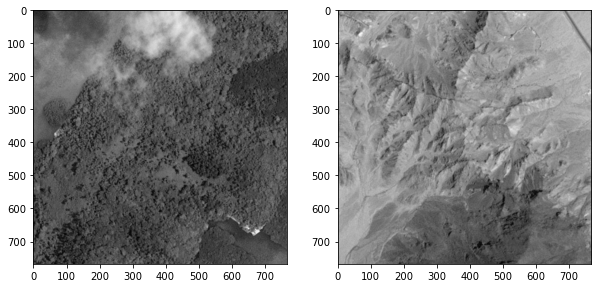

In [4]:
plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.imshow(forest_example, cmap="gray")

plt.subplot(122)
plt.imshow(desert_example, cmap="gray")
plt.show()

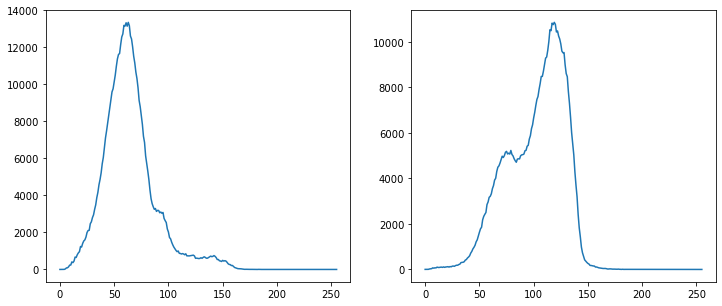

In [5]:
forest_hist = cv2.calcHist([forest_example.ravel()], [0], None, [256], [0, 256])
desert_hist = cv2.calcHist([desert_example.ravel()], [0], None, [256], [0, 256])

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(forest_hist)

plt.subplot(122)
plt.plot(desert_hist)
plt.show()

In [6]:
MODE_DELIMETER = 100

In [7]:
forest_list = []
desert_list = []
for i, image in enumerate(forest_desert_images):
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray.ravel()], [0], None, [256], [0, 256])
    if np.argmax(hist) < MODE_DELIMETER:
        forest_list += [i]
    else:
        desert_list += [i]


In [8]:
print("Forest images: ", forest_list)
print("Desert images: ", desert_list)

Forest images:  [0, 1, 2, 3, 5, 7, 8, 9]
Desert images:  [4, 6, 10, 11, 12, 13, 14, 15, 16]


# Задача №2 - Раздели объекты в шуме

Дано зашумленное изображение с 3 объектами: круг, треугольник и фон. Треубется выдлеить каждый объект, фон, круг и треугольник в бинарные маски. То есть треубется найти геометрическое место каждого объекта на изображении. Незашумленное изображение приведено __только__ для оценки качества решения. Запрещено использовать любую инофрмацию о незашумленном изоьражении в решении. 

Придумайте способ численной оценки качества полученного результата.

<table><tr>
    <td> <img src="segmentation/gt.png" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="segmentation/noise.png" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

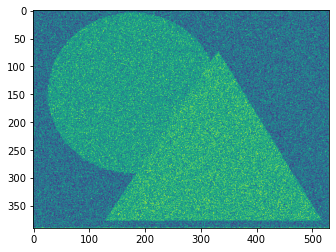

In [9]:
noisy_image = cv2.imread("segmentation/noise.png")
noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2GRAY)
# Вывожу специально без cmap, т.к. тут разница в цветах виднее
plt.imshow(noisy_image)

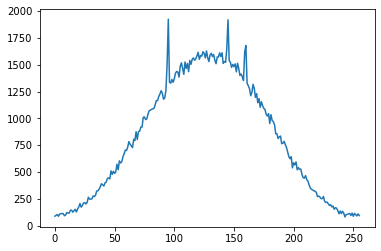

In [10]:
noisy_image_hist = cv2.calcHist([noisy_image.ravel()], [0], None, [256], [0, 256])
plt.plot(noisy_image_hist)

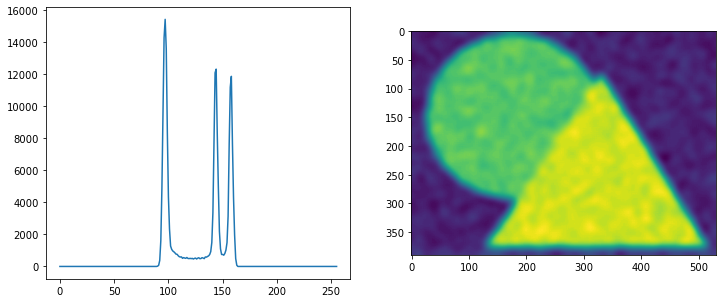

In [11]:
preprocesed = cv2.GaussianBlur(noisy_image, (31, 31), sigmaX=7, sigmaY=7)
dilated_image_hist = cv2.calcHist([preprocesed.ravel()], [0], None, [256], [0, 256])

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(dilated_image_hist)

plt.subplot(122)
plt.imshow(preprocesed)

In [46]:
NOISE_DELIMETER = 135
COLOR_DELIMETER = 150
EPSILON = 10

shapes = preprocesed.copy()
shapes[shapes < NOISE_DELIMETER] = 0

circle = shapes.copy()
circle[circle > COLOR_DELIMETER] = 0

triangle = shapes.copy()
triangle[triangle < COLOR_DELIMETER] = 0

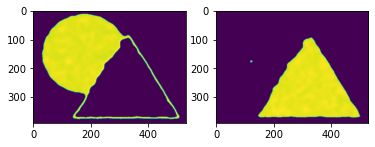

In [47]:
plt.subplot(121)
plt.imshow(circle)

plt.subplot(122)
plt.imshow(triangle)

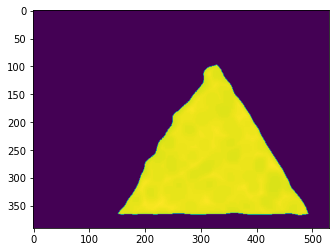

In [48]:
new_triangle = cv2.erode(triangle, np.ones((5, 5)), iterations = 2)
plt.imshow(new_triangle)

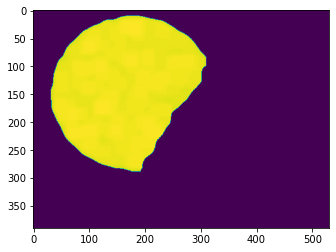

In [49]:
new_circle = cv2.erode(circle, np.ones((5, 5)), iterations = 4)
new_circle = cv2.dilate(new_circle, np.ones((5, 5)), iterations = 4)
plt.imshow(new_circle)

# Задача №3 - Найди клетки

Даны снимки раковых клеток. Существует задача - определить стадию рака клетки по такому изображению. Для того, чтобы подойти к решению классификации рака клетки, необходимо сначала подготовить данные.

Исходные изображения в реальных задачах могут быть очень большого размера (более 20000 px). Однако из визуального анализа можно заметить, что большая часть этих снимков пустая и не несет в себе полезную информацию.

Ваша задача выделить небольшие ячейки изображений из исходного так, чтобы на ячейках было только изображение клетки.

Пример исходного изображения и нарезанных ячеек клетки.
<img src="../img/cell_example.png" alt="Drawing" style="width: 500px;"/>

В качестве аргументов у функции будут значения:
1. исходное изображние;
2. размер ячейки;
3. количество ячеек.

__Доп вопрос__ - как можно выяснить какие нужны значения аргументов, чтобы они подходили для большинства исходных снимков?

In [22]:
cell_path = "cells/train"
cell_images = [cv2.imread(cell_path+str(i)+"_1.jpeg") for i in range(6)]

In [50]:
def segment(image, kernel_size, kernel_count):
    # Количество информации, которое мы хотим получать от одного квадрата сегментации
    INFORMATION_CAPACITY = 1 / ((image.shape[0] // kernel_size) * (image.shape[1] // kernel_size))
    KERNEL = np.ones(kernel_size)
    
    image = cv2.copyMakeBorder(
        image, kernel_size, kernel_size, kernel_size, kernel_size, cv2.BORDER_CONSTANT, value=(255, 255, 255)
    )

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    thresh = thresh // 255
    
    pathes = dict()
    for i in range(0, thresh.shape[0]-kernel_size, kernel_size):
        for j in range(0, thresh.shape[1]-kernel_size, kernel_size):
            corr = np.sum(thresh[i:i+kernel_size, j:j+kernel_size] * KERNEL)
            information = corr / kernel_size**2
            if information > INFORMATION_CAPACITY:
                # Ключом являются (j, i) компоненты, а не (i, j)
                # специально для удобства отрисовки выделеных частей на
                # оригинальном изображении
                pathes[(j, i)] = information
    
    # Отрисовка всех квадратов, которые были выделены
    pathed = image.copy()
    color = (0, 0, 0)
    thickness = 25
    for dot in pathes.keys():
        start_point = dot
        end_point = (dot[0] + kernel_size, dot[1] + kernel_size)
        pathed = cv2.rectangle(pathed, start_point, end_point, color, thickness)

    # Сортировка выделеных квадратов по их информативности 
    sorted_pathes = {k: v for k, v in sorted(pathes.items(), key=lambda item: item[1], reverse=True)}

    # Отрисовка первых kernel_count по информативности квадратов
    pathed_best = image.copy()
    segmented_parts = []
    color = (255, 0, 0)
    for i, dot in enumerate(sorted_pathes.keys()):
        if i >= kernel_count:
            break
        start_point = dot
        end_point = (dot[0] + kernel_size, dot[1] + kernel_size)
        segmented_parts += [image[dot[1]:dot[1]+kernel_size, dot[0]:dot[0]+kernel_size]]
        pathed_best = cv2.rectangle(pathed_best, start_point, end_point, color, thickness)

    row_len = int(kernel_count**0.5)
    preprocesed_rows = [
        np.hstack(segmented_parts[i:i+row_len]) for i in range(0, kernel_count-row_len, row_len)
    ]

    left_over = kernel_count - row_len * len(preprocesed_rows)
    white_count = row_len - left_over
    mr_white = 255 * np.ones((kernel_size, kernel_size*white_count, 3), dtype=np.uint8)
    jessy = np.hstack(segmented_parts[-left_over:]) 
    
    preprocesed_rows += [
        np.hstack([jessy, mr_white])
    ]
    preprocesed_image = np.vstack(preprocesed_rows)

    return pathed, pathed_best, preprocesed_image

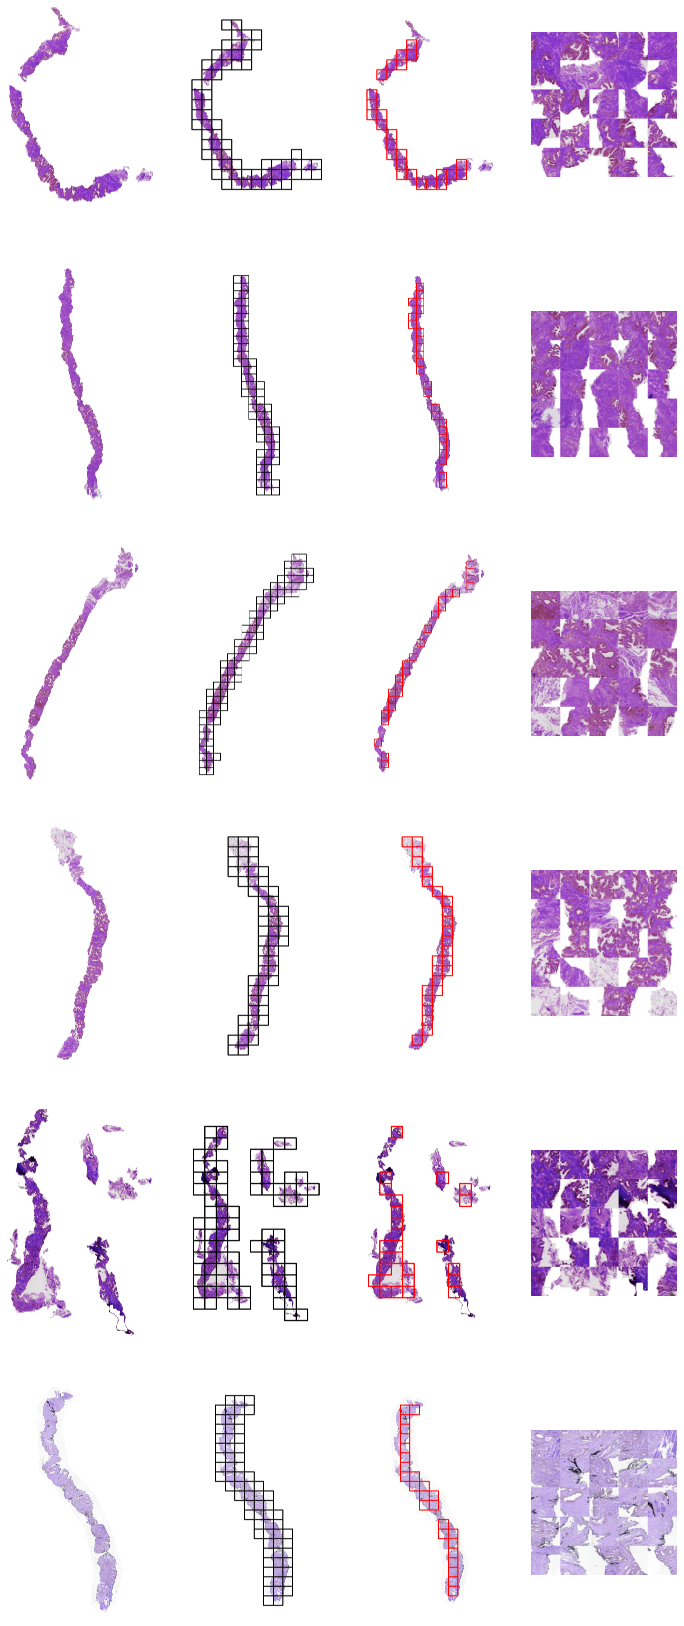

In [51]:
fig, ax = plt.subplots(6, 4, figsize=(12, 5*6))

for i, cell in enumerate(cell_images):
    pathed, pathed_best, preprocesed_image = segment(cell, 250, 25)
    ax[i][0].imshow(cell)
    ax[i][1].imshow(pathed)
    ax[i][2].imshow(pathed_best)
    ax[i][3].imshow(preprocesed_image)
    ax[i][0].axis('off')
    ax[i][1].axis('off')
    ax[i][2].axis('off')
    ax[i][3].axis('off')
